In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

In [3]:
cluster = SLURMCluster(queue='analysis', cores=4, project='gfdl_o',
                       memory="24GB", walltime="00:30:00",
                       scheduler_options={"dashboard_address": "localhost:8726"})

In [4]:
cluster.scale(2)

In [5]:
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://140.208.147.171:41951 Dashboard: http://140.208.147.171:8726/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Decadal variability of WMT in GFDL's OM4
JRA forcing  

18/11/20
- I'm going to attempt to calculate the tendencies using both the heat and salt tendencies and the surface mass flux. This is bassically going from MOM5_elements, section 36.8.7. It will be a little hacky.
- The vertical integral of the material tendency is everywhere equal to the tendency of the vertically-extensive quantity (because of continuity) *except* at the very surface ocean, where the kinematic boundary condition leads to an addition of water that *can* impact the material tendency without changing the vertically extensive quantity (consider the impact of freshwater flux on salinity versus salt).
- I'm pretty sure I got the form of the tendencies correct, accounting for the flux of freshwater. This changed the shape of the salt/FW contribution substantially, but it still looks very far from observtaions.
    - so, toward the bottom of this notebook I am looking just at the surface fluxes and seeing what the seasonality does to the look of the fluxes.
- **OK** with monthly surfaces fluxes, the result looks pretty reasonable. Indeed, also with annual means the surface-forcing-derived transformation looks OK (if a little wonky). The issue in the 3D fields is that the mixing term looks particularly weird (not necesssarily wrong).
    - there is still a substantial issue with something happening around $\gamma = 27.4$. It looks like this is a real feature - must investigate further.

16/11/20
- As it transpires, the issue here was that the salt tendencies do not account for freshwater fluxes (freshwater flux does not change salt)
    - so these salt tendencies cannot be used to recover the density tendency
- this is going to take a broader revamping of my approach, to frame this calculation in simple terms

20/10/20
- Further consideration of salt tendency has made me realise that I am conflating salt and salinity
    - the tendency of salt divided by time-mean thickness is _not_ the salinity tendency - this now seems obvious
    - this is the reason why the salt tendency looks so weird, it is not consistent with a freshwater flux, which in a model that applies a real volume flux will have no impact on the salt tendency
    - instead the salt tendency picks up only the _direct_ salt flux, which comes from restoring and basal ice melt

14/10/20
- check forcing signs etc. Am I getting this right? Confirm salt budget closure.
- surface forcing only? what terms do I need, and which are there? Gustavo tutorial may indicate this.
- necessity of monthly output

Budget closure issues

- SALT budget has residual noise - most likely because of salt restoring, diagnostics for which are not available
    - not true in fact, since restoring is including in buoyancy forcing
    - noise remains undiagnose
- HEAT budget has residual associated with geothermal heat - internal_heat_heat_tendency not included as diagnostic
- SALT tendencies are, in fact, NEGATIVE salt tendencies, - see for example, the boundary forcing at rivers, where positive salt tendencies are found in regions corresponding to positive freshwater fluxes, i.e. negative salt fluxes. CONFIRM THIS IN THE SOURCE CODE.
    - This, in fact, is not the case. Instead, it looks as though the _restoring_ is dominating the forcing, and driving the solution back to climatology. This makes it look as though the tendencies are of the opposite sign from what we expect (based on surface flux knowledge).
    
So, again, it seems that I need to redo the simulation from a restart, and output the diagnostic for the restoring separately.



In [7]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram
import gsw
import wmt_bgc.basic as wmt
import fastjmd95 as jmd95
from xgcm import Grid
from dask.diagnostics import ProgressBar
%matplotlib inline

In [8]:
# Load the data
config = 'OM4p25_JRA55do1.4_0netfw_cycle6'
rootdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/'+config+'/gfdl.ncrc4-intel16-prod/pp/'
# 3D tendencies
print('3D tendencies')
pp = 'ocean_annual_z'
localdir = '/ts/annual/5yr/'
filename = pp+'.2003*.nc'
ds = xr.open_mfdataset(rootdir+pp+localdir+filename)
grid = xr.open_dataset(rootdir+pp+'/'+pp+'.static.nc')
# Load gamma_n
print('gamma_n')
gammadir = '/archive/gam/so_decadal_variability/OM4p25_JRA55do1.4_0netfw_cycle6/'
localdir = '/'
ds = xr.merge([ds,xr.open_mfdataset(gammadir+pp+localdir+filename)['gamma_n']])
ds['gamma_n'] = ds['gamma_n'].where(ds['gamma_n']>0,np.nan)
# Load surface fluxes
print('Surface fluxes')
pp = 'ocean_monthly'
localdir = '/ts/monthly/5yr/'
filename = pp+'.2003*.nc'
ds_surf = xr.open_mfdataset(rootdir+pp+localdir+filename)[['wfo','sos','tos']]
# Specify some constants
Cp = 3992.
rho0 = 1035.

3D tendencies
gamma_n
Surface fluxes


In [9]:
# Take annual means of surface flux data
ds_surf_annual = ds_surf.groupby('time.year').mean('time').rename({'year':'time'}).assign_coords({'time':ds['time']})
# Grab 
ds = xr.merge([ds,ds_surf_annual])

In [10]:
# Build an xgcm grid object
# Create a pseudo-grid in the vertical
grid['z_l'] = ds['z_l']
grid['z_i'] = ds['z_i']
grid['dzt'] = grid['z_l'].copy(data=grid['z_i'].diff('z_i'))
grid = grid.squeeze() # Get rid of any remnant time variables

# Fill in nans with zeros
grid['dxt'] = grid['dxt'].fillna(0.)
grid['dyt'] = grid['dyt'].fillna(0.)
grid['dzt'] = grid['dzt'].fillna(0.)
grid['areacello'] = grid['areacello'].fillna(0.)
grid['volcello'] = ds['volcello'].fillna(0.)
metrics = {
    ('X',): ['dxt','dxCu','dxCv'], # X distances
    ('Y',): ['dyt','dyCu','dyCv'], # Y distances
    ('Z',): ['dzt'], # Z distances
    ('X', 'Y'): ['areacello'], # Areas
    ('X', 'Y', 'Z'): ['volcello'], # Volumes
}
coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
        'Z': {'center': 'z_l', 'outer': 'z_i'} }
xgrid = Grid(grid, coords=coords, metrics=metrics, periodic=['X'])

In [11]:
# Specifications for heat and salt budgets
variables = {'heat':'thetao','salt':'so'}
processes=['boundary forcing','vertical diffusion','neutral diffusion',
           'frazil ice','internal heat']
terms = {}
terms['heat'] = {'boundary forcing':'boundary_forcing_heat_tendency',
         'vertical diffusion':'opottempdiff',
         'neutral diffusion':None,
         'frazil ice':'frazil_heat_tendency',
         'internal heat':None}
terms['salt'] = {'boundary forcing':'boundary_forcing_salt_tendency',
         'vertical diffusion':'osaltdiff',
         'neutral diffusion':'osaltpmdiff',
         'frazil ice':None,
         'internal heat':None}

In [12]:
# Preprocess
# Isolate Southern Ocean
ds_SO = ds.sel(yh=slice(-90,-30),yq=slice(-90,-30))

# Pressure from depth
ds_SO['p'] = wmt.gsw_p_from_z(-ds_SO['z_l'],grid['geolat'])

# Calculate density
density = 'gamma_n'
if density=='sigma0':
    ### sigma0
    # Calculate density
    ds_SO['density'] = wmt.gsw_sigma0(ds_SO['so'],ds_SO['thetao'])
    # Calculate alpha and beta
    alpha = wmt.gsw_alpha(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = wmt.gsw_beta(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
elif density=='jmd95':
    ### jmd95
    # Calculate density
    ds_SO['density'] = jmd95.rho(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    # Calculate alpha and beta
    alpha = jmd95.drhodt(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = jmd95.drhods(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
elif density=='mjd05':
    ### mjd05
    # Calculate density
    ds_SO['density'] = wmt.sigmantr_mjd05(ds_SO['so'],ds_SO['thetao'])
    # Calculate alpha and beta
    alpha = wmt.gsw_alpha(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = wmt.gsw_beta(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
elif density=='gamma_n':
    ### mjd05
    # Calculate density
    ds_SO['density'] = ds['gamma_n']
    # Calculate alpha and beta
    alpha = wmt.gsw_alpha(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = wmt.gsw_beta(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    
# Interpolate density to the cell interfaces
ds_SO['density_i'] = xgrid.interp(ds_SO['density'],'Z',boundary='extrapolate').chunk({'z_i':-1})

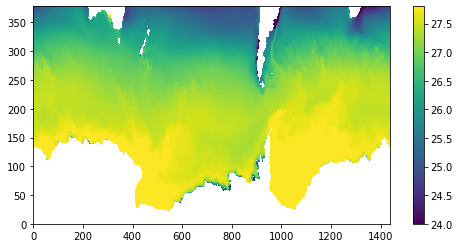

In [13]:
fig,ax=plt.subplots(figsize=(8,4))
im=ax.pcolormesh(ds_SO['density'].isel(z_l=0).mean('time'),vmin=24,vmax=27.8)
plt.colorbar(im,ax=ax)

### Density tendency from heat, salt, and mass

In [14]:
# Assign a z-coordinate to the surface fluxes
Q_m = ds['wfo'].expand_dims({'z_l':ds['z_l']}).where(ds['z_l']==ds['z_l'][0],0)
S = ds['sos'].expand_dims({'z_l':ds['z_l']}).where(ds['z_l']==ds['z_l'][0],0)
T = ds['tos'].expand_dims({'z_l':ds['z_l']}).where(ds['z_l']==ds['z_l'][0],0)
# And define S and T of inflowing mass
S_m = xr.zeros_like(S)
T_m = T

In [15]:
# Just do boundary fluxes initially
heat_tend = ds['boundary_forcing_heat_tendency']
salt_tend = ds['boundary_forcing_salt_tendency']

drho_heat = -(alpha/Cp)*(heat_tend - Cp*Q_m*(T-T_m))
drho_salt = beta*(salt_tend*1000-Q_m*(S-S_m))

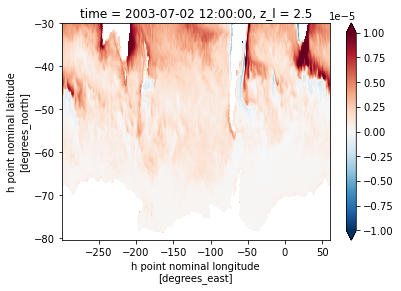

In [16]:
drho_heat.isel(time=0,z_l=0).plot(vmin=-1E-5)

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


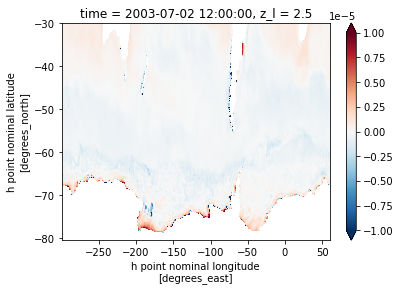

In [47]:
drho_salt.isel(time=0,z_l=0).plot(vmin=-1E-5)

### Checking budget closure

In [7]:
# Check salt budget closure

# Define a function to sum up the terms on the LHS and RHS of the tracer
# conservation equation
def calc_budget(ds,terms):
    lhs = xr.Dataset()
    rhs = xr.Dataset()
    for key in terms.keys():
        lhs[key] = xr.zeros_like(ds[terms[key][0]])
        for term in terms[key][0:3]:
            # Flip the sign for the advective tendencies
            if term in ['opottemptend','osalttend','dhdt']:
                sign=1
            else:
                sign=-1
            lhs[key] += sign*ds[term]
        rhs[key] = xr.zeros_like(ds[terms[key][3]])
        for term in terms[key][3:]:
            sign=1
            rhs[key] += sign*ds[term]
    return lhs, rhs

termsnow = {}
termsnow['heat'] = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
                 'boundary_forcing_heat_tendency','opottempdiff',
                 'frazil_heat_tendency']
termsnow['salt'] = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
                 'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
lhs,rhs = calc_budget(ds,termsnow)

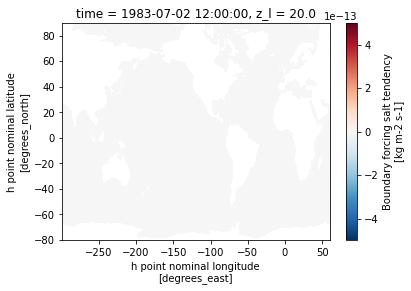

In [25]:
ds['boundary_forcing_salt_tendency'].isel(z_l=2).isel(time=25).plot(vmin=-0.5E-12)

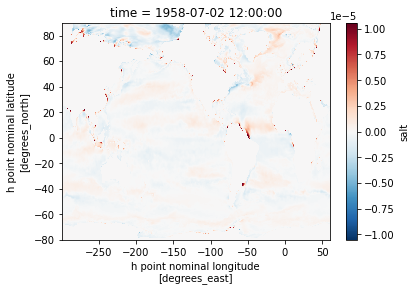

In [43]:
rhs['salt'].isel(time=0).sum('z_l').plot()

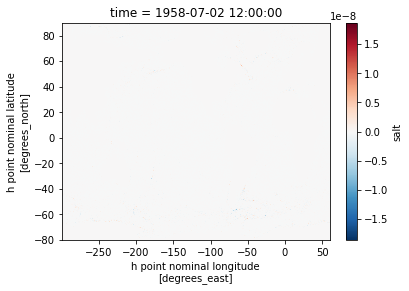

In [44]:
(lhs['salt']-rhs['salt']).isel(time=0).sum('z_l').plot()

In [49]:
# Define a short function to calculate the tendency
# of the locally-referenced potential density
# from heat and salt content tendencies
def densitytendency_from_heat_and_salt(
    heat_tend,salt_tend,alpha=1E-4,beta=1E-3,Cp=3992.0):

    densitytendency_heat = -(alpha/Cp)*heat_tend
    densitytendency_salt = beta*salt_tend*1000 # Factor of 1000 converts salt_tend to g m-2 s-1
    densitytendency = densitytendency_heat + densitytendency_salt
    return densitytendency, densitytendency_heat, densitytendency_salt

Todo
- come up with a more robust way of specifying the direction of heat of salt fluxes
- It looks like there's something wrong with the salt flux. It's impact on density is positive where it should be negative.
- revisit densitytendency from heat and salt - is it correct?
- could it be the calculation of alpha and beta?

In [50]:
# Calculate density tendency
drhodt = xr.Dataset()
drhodt_heat = xr.Dataset()
drhodt_salt = xr.Dataset()
for process in processes:
    term_heat = terms['heat'][process]
    term_salt = terms['salt'][process]

    # If there is no contribution of heat or salt for this process,
    # set to zero. A little hacky, requiring that the first process
    # is non-zero for both heat and salt.
    if term_heat is not None:
        heat_tend = ds_SO[term_heat]
    else:
        heat_tend = xr.zeros_like(ds_SO[terms['heat'][processes[0]]])

    if term_salt is not None:
        salt_tend = ds_SO[term_salt]
    else:
        salt_tend = xr.zeros_like(ds_SO[terms['salt'][processes[0]]])

    (drhodt[process],
     drhodt_heat[process],
     drhodt_salt[process]) = densitytendency_from_heat_and_salt(
        heat_tend,
        salt_tend,
        alpha=alpha,
        beta=beta,Cp=Cp)
    
    # For boundary forcing, include contribution to material derivative from mass flux
    if process=='boundary forcing':
        drhodt_salt[process] += -alpha*Q_m*(T-T_m)
        drhodt_salt[process] += -beta*Q_m*(S-S_m)
        drhodt[process] = drhodt_heat[process] + drhodt_salt[process]

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


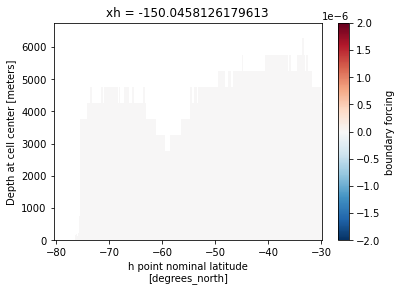

In [10]:
# Check signs
drhodt_salt['boundary forcing'].sel(xh=-150,method='nearest').mean('time').plot(vmin=-2E-6)

In [51]:
#### B-FACTOR ###
b = xr.ones_like(ds_SO['density'])

In [52]:
# Specify the tracer range and bin widths (\delta\lambda) for the calculation
delta_l = 0.1
lmin = 26
lmax = 28.5
bins = np.arange(lmin,lmax,delta_l)

Todo: 
- b-factor *also* needs to be transformed, so order in which you specify the integrand is important

In [53]:
# Transform each of the diffusive tendency terms onto the density grid
# And integrate in each temperature layer and divide by \delta density
G = xr.Dataset()
for process in processes:
    var_on_dens = xgrid.transform(
        drhodt[process],'Z',target=bins,target_data=ds_SO['density_i'],method='conservative')
    G[process] = (
        (rho0*var_on_dens)*grid['areacello']).sum(['xh','yh'])/np.diff(bins)
G['total'] = xr.zeros_like(G[processes[0]])
for process in processes:
    G['total'] += G[process]

In [54]:
# Separately evaluate for heat-driven and salt-driven
# HEAT
G_heat = xr.Dataset()
for process in processes:
    var_on_dens = xgrid.transform(
        drhodt_heat[process],'Z',target=bins,target_data=ds_SO['density_i'],method='conservative')
    G_heat[process] = (
        (rho0*var_on_dens)*grid['areacello']).sum(['xh','yh'])/np.diff(bins)
# SALT
G_salt = xr.Dataset()
for process in processes:
    var_on_dens = xgrid.transform(
        drhodt_salt[process],'Z',target=bins,target_data=ds_SO['density_i'],method='conservative')
    G_salt[process] = (
        (rho0*var_on_dens)*grid['areacello']).sum(['xh','yh'])/np.diff(bins)

In [55]:
with ProgressBar():
    G.load()
    G_heat.load()
    G_salt.load()

[####                                    ] | 11% Completed |  8.9s

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 42.3s
[########################################] | 100% Completed | 23.8s
[############                            ] | 30% Completed |  8.4s

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 27.7s


CPU times: user 24 ms, sys: 3 ms, total: 27 ms
Wall time: 25.5 ms


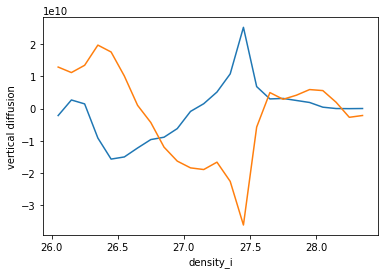

In [56]:
%%time
G_heat['boundary forcing'].mean('time').plot()
G_heat['vertical diffusion'].mean('time').plot()

CPU times: user 24 ms, sys: 2 ms, total: 26 ms
Wall time: 24.4 ms


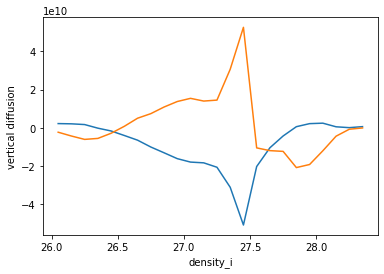

In [57]:
%%time
G_salt['boundary forcing'].mean('time').plot()
G_salt['vertical diffusion'].mean('time').plot()

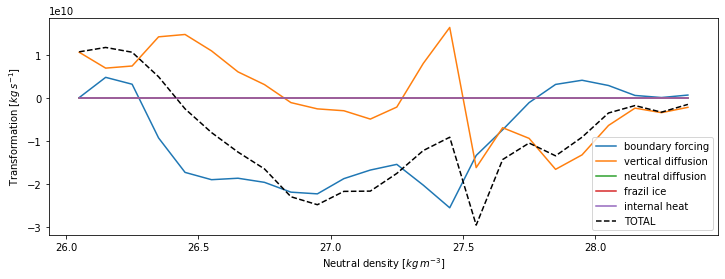

In [58]:
fig, ax = plt.subplots(figsize=(12,4))
G['total'] = xr.zeros_like(G[processes[0]].mean('time'))
for process in processes:
    ax.plot(G['density_i'],G[process].mean('time'),label=process)
    G['total'] += G[process].mean('time')
ax.plot(G['density_i'],G['total'],color='k',linestyle='--',label='TOTAL')
ax.legend()
ax.set_xlabel('Neutral density [$kg\,m^{-3}$]')
ax.set_ylabel('Transformation [$kg\,s^{-1}$]');

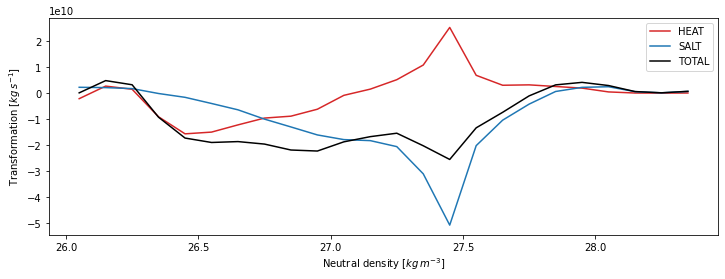

In [60]:
total = xr.zeros_like(G[processes[0]].mean('time'))
total_heat = xr.zeros_like(G_heat[processes[0]].mean('time'))
total_salt = xr.zeros_like(G_salt[processes[0]].mean('time'))
# for process in processes:
process = 'boundary forcing'
total += G[process].mean('time')
total_heat += G_heat[process].mean('time')
total_salt += G_salt[process].mean('time')
    
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(G_heat['density_i'],total_heat,color='tab:red',linestyle='-',label='HEAT')
ax.plot(G_salt['density_i'],total_salt,color='tab:blue',linestyle='-',label='SALT')
ax.plot(G['density_i'],total,color='k',linestyle='-',label='TOTAL')
ax.legend()
ax.set_xlabel('Neutral density [$kg\,m^{-3}$]')
ax.set_ylabel('Transformation [$kg\,s^{-1}$]');

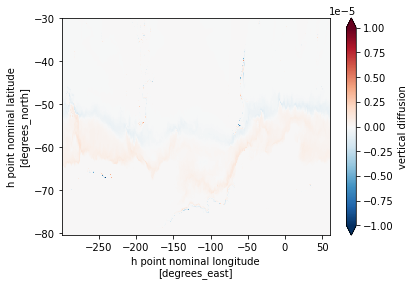

In [57]:
# Try to see what's going on around 27.4
ind = (ds_SO['gamma_n']>27.3) & (ds_SO['gamma_n']<27.5)
val = drhodt['vertical diffusion'].where(ind,np.nan)
val.sum('z_l').mean('time').plot(vmin=-1E-5)

#xh=slice(-75,-25),yh=slice(-50,-30) vmin=-5E-6

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


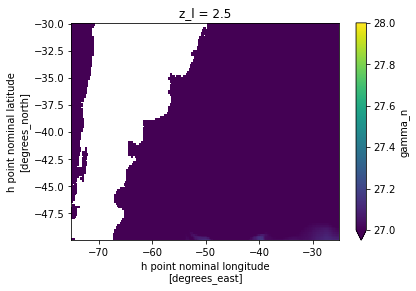

In [52]:
ds['gamma_n'].sel(xh=slice(-75,-25),yh=slice(-50,-30)).isel(z_l=0).mean('time').plot(vmin=27,vmax=28)

In [187]:
from dask.diagnostics import ProgressBar

In [188]:
outdir = '/work/gam/projects/so_decadal_variability/data/processed/'+config
outfile = density+'_'+str(delta_l)+'.G.nc'
with ProgressBar():
    G.to_netcdf(outdir+'/'+outfile)

[########################################] | 100% Completed |  4min  1.9s


### Surface fluxes and seasonality

In [4]:
# Load the data
config = 'OM4p25_JRA55do1.4_0netfw_cycle6'
rootdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/'+config+'/gfdl.ncrc4-intel16-prod/pp/'
# Load surface fluxes
print('Surface fluxes')
pp = 'ocean_monthly'
localdir = '/ts/monthly/5yr/'
filename = pp+'.200*.nc'
ds = xr.open_mfdataset(rootdir+pp+localdir+filename)

Surface fluxes


In [10]:
# Preprocess
# Isolate Southern Ocean
ds_SO = ds.sel(yh=slice(-90,-30),yq=slice(-90,-30))
# Pressure from depth
ds_SO['p'] = wmt.gsw_p_from_z(np.array([-2.5]),grid['geolat'])
alpha = wmt.gsw_alpha(ds_SO['sos'],ds_SO['tos'],ds_SO['p'])
beta = wmt.gsw_beta(ds_SO['sos'],ds_SO['tos'],ds_SO['p'])
ds_SO['density'] = wmt.gsw_sigma0(ds_SO['sos'],ds_SO['tos'])

In [11]:
drhodt = xr.Dataset()
drhodt['heat'] = -(alpha/Cp)*(ds['hfds']-Cp*ds['wfo']*(ds['tos']-ds['tos']))
drhodt['salt'] = beta*(ds['sfdsi']-ds['wfo']*(ds['sos']-xr.zeros_like(ds['tos'])))
drhodt['total'] = drhodt['heat']+drhodt['salt']

In [13]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    drhodt.load()

[########################################] | 100% Completed | 11.8s


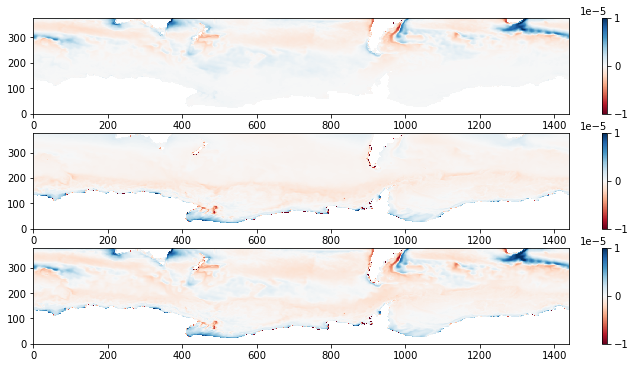

In [19]:
fig,(ax0,ax1,ax2) = plt.subplots(figsize=(12,6),nrows=3)
def plot(ax,var):
    im = ax.pcolormesh(var,vmin=-1E-5,vmax=1E-5,cmap='RdBu')
    plt.colorbar(im,ax=ax)
plot(ax0,drhodt['heat'].mean('time'))
plot(ax1,drhodt['salt'].mean('time'))
plot(ax2,drhodt['total'].mean('time'))

In [28]:
def calc_G(drhodt,density,A,edges):
    weight = density*drhodt*A
    nanmask=np.isnan(weight)
    G = histogram(density.where(~nanmask),bins=[edges],weights=weight.where(~nanmask),dim=['xh','yh'])/np.diff(edges)
    return G

In [29]:
# Done properly
edges = np.arange(26,28.5,0.1)
G = xr.Dataset()
for term in ['heat','salt','total']:
    G[term] = calc_G(drhodt[term],
                     ds_SO['density'],
                     grid['areacello'],
                     edges)

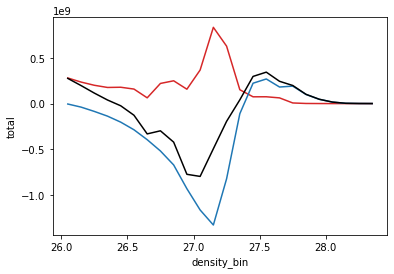

In [31]:
G['heat'].mean('time').plot(color='tab:red')
G['salt'].mean('time').plot(color='tab:blue')
G['total'].mean('time').plot(color='k')

In [34]:
# Done on temporal averages
drhodt_mean = drhodt.groupby('time.year').mean('time').rename({'year':'time'})
ds_SO_mean = ds_SO.groupby('time.year').mean('time').rename({'year':'time'})

G_mean = xr.Dataset()
for term in ['heat','salt','total']:
    G_mean[term] = calc_G(drhodt_mean[term],
                          ds_SO_mean['density'],
                          grid['areacello'],
                          edges)

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


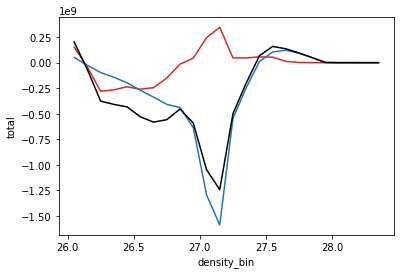

In [35]:
G_mean['heat'].mean('time').plot(color='tab:red')
G_mean['salt'].mean('time').plot(color='tab:blue')
G_mean['total'].mean('time').plot(color='k')